Welcome! We first import the needed packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Goal

The goal of this part of the project is to make a linear model to predict mortality rates in different states and countries. 

# Preparing Data

## 1. Loading the data

#1 Let's first load the data and clean it a little.

In [2]:
original_data1 = pd.read_csv('4.18states.csv')
data1 = original_data1
data1

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,Alaska,US,2020-04-18 22:32:47,61.3707,-152.4044,314,9,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,84000002,USA,1615.226458,12.420382
2,American Samoa,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,NaN,16,ASM,5.391708,NaN
3,Arizona,US,2020-04-18 22:32:47,33.7298,-111.4312,4724,180,539.0,4544.0,4.0,64.901548,51045.0,566.0,3.810330,84000004,USA,701.291175,11.981372
4,Arkansas,US,2020-04-18 22:32:47,34.9697,-92.3731,1744,38,703.0,1706.0,5.0,67.361213,24141.0,291.0,2.178899,84000005,USA,932.435235,16.685780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Xinjiang,China,NaN,41.1129,85.2401,76,3,73.0,0.0,NaN,0.305589,NaN,NaN,3.947368,15629,CHN,NaN,NaN
136,Yukon,Canada,NaN,64.2823,-135.0000,9,0,0.0,9.0,NaN,21.909538,NaN,NaN,0.000000,12412,CAN,NaN,NaN
137,Yunnan,China,NaN,24.9740,101.4870,184,2,177.0,5.0,NaN,0.380952,NaN,NaN,1.086957,15630,CHN,NaN,NaN
138,Zhejiang,China,NaN,29.1832,120.0934,1268,1,1246.0,21.0,NaN,2.210214,NaN,NaN,0.078864,15631,CHN,NaN,NaN


In [3]:
original_data2 = pd.read_csv('abridged_couties.csv')
data2 = original_data2

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# EDA

## Mortality rate

Let's do some visualization and see whether there are some relationship between different variables.

### Mortality rates' outlier and overlapping points

Plot the distribution of mortality rate and see if we can find something interesting.

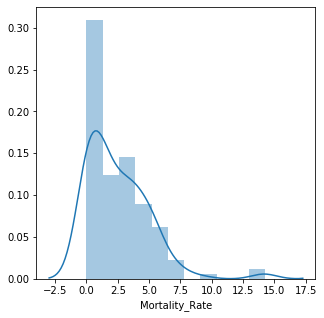

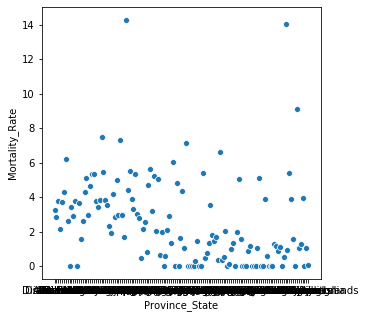

In [5]:
mortality_rate = data1['Mortality_Rate']
#operate_data2['mortality_rate'] = operate_data2[operate_data2['State'].isin(mortality_rate.index)]

plt.figure(figsize = (5,5))
sns.distplot(data1['Mortality_Rate'])
plt.figure(figsize = (5,5))
sns.scatterplot(x=data1['Province_State'],y=data1['Mortality_Rate'])

In [6]:
#mortality_rate.value_counts()
#data1[data1['Mortality_Rate']>8]

Two interesting things to note: 

1: overlapping: there are 28 points of 0 mortality rate.

2: outliers: three states have mortality rate>8%. It seems like they have high mortality rates because they have pretty small population? The confirmed cases and death cases are pretty low.

## Update state representation

For table 2, there are >150 entries with NaN values in "State". Here we add a new column to table 2 called "State update", where we fill in the NaN values for State based on the state abbreviation column.

In [7]:
state_abbreviation = data2.groupby(['StateName', 'State']).agg(sum)#['StateName']
state_dict_original = state_abbreviation.reset_index()[['StateName', 'State']]
new_state_df = pd.DataFrame({'StateName': ['AK','VI', 'PR', "HI", 'GU',"AS",'MP'], 
                             'State': ['Alaska', 'Virgin Islands','Puerto Rico','Hawaii', "Guam",'American Samoa'
                                      ,'Northern Marianas']})
state_dict_combined = pd.concat([state_dict_original, new_state_df])
state_dict = state_dict_combined.set_index('StateName')['State']
mapped_state = data2['StateName'].map(state_dict)
mapped_state.isna().sum()
#state_dict

0

## Append mortality to table 2

Here we add a new column to table 2 called "Mortality Rate", which corresponds to the "Mortality_Rate" column in table 1, and mapped the mortality rate to each county based on which state it is in.

**Question about methodology**: Is it valid to take the aggregate data from a bigger granularity (state) to a data of lower granularity (county)? The mortality rate in different county is different, and since each county has different population, we cannot generalize one state's mortality rate to all counties in it?



In [8]:
data2['State updated'] = mapped_state
mortality_dict = data1[data1['Country_Region'] == 'US'][['Province_State', 'Mortality_Rate']].set_index('Province_State')['Mortality_Rate']
mapped_mortality = data2['State updated'].map(mortality_dict)
mapped_mortality.isna().sum() #should be American Samoa 
data2['Mortality Rate'] = mapped_mortality
#data2


## Feature Selection

To begin with, we first take an "educated guess" and select a few features of interest in the second table, which we think will affect the death rate of Covid 19. 

We also wants to drop American Samoa and Northern Marianas because they do not have mortality rates. We also manually fill in the mortality rate for DC (don't know why it was not there). 

In [9]:
operate_data2 = data2[['CountyName', 'State updated', 'stay at home', 'public schools', '>500 gatherings',
                                 'Mortality Rate']][data2['State updated'] != 'American Samoa'][data2['State updated'] != 'Northern Marianas']
#operate_data2[operate_data2['CountyName']=='Washington']
operate_data2['Mortality Rate'] = operate_data2['Mortality Rate'].fillna(3.413353)
operate_data2_with_states = operate_data2
operate_data2_with_states

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,CountyName,State updated,stay at home,public schools,>500 gatherings,Mortality Rate
0,Autauga,Alabama,737519.0,737500.0,737497.0,3.247029
1,Baldwin,Alabama,737519.0,737500.0,737497.0,3.247029
2,Barbour,Alabama,737519.0,737500.0,737497.0,3.247029
3,Bibb,Alabama,737519.0,737500.0,737497.0,3.247029
4,Blount,Alabama,737519.0,737500.0,737497.0,3.247029
...,...,...,...,...,...,...
3239,Kalawao,Hawaii,737509.0,737507.0,737509.0,1.567944
3240,Ciales Municipio,Puerto Rico,NaN,737500.0,NaN,5.366726
3241,Humacao Municipio,Puerto Rico,NaN,737500.0,NaN,5.366726
3242,New York City,New York,NaN,NaN,NaN,7.310767


##  Missing Values

#2 Now we will look at missing values.

In [10]:
operate_data2.isnull().sum()

CountyName           0
State updated        0
stay at home       582
public schools      15
>500 gatherings    211
Mortality Rate       0
dtype: int64

We should replace the NaN values of 'stay at home', 'public school', and '>500 gatherings' with the average value in their states. 

**For Now** for simplicity I will replace all values in the three columns with an average value of the whole table (which is incorrect but convenient). 

**An idea** We can also fill all the NaN values with .isna(method = 'ffill') to fill all the values with previous valid values, which saves more time and should work well, given that adjacent counties are likely to be in the same state.


In [11]:
operate_data2_with_states['stay at home'] = operate_data2_with_states['stay at home'].fillna(np.mean(operate_data2_with_states['stay at home']))
operate_data2_with_states['public schools'] = operate_data2_with_states['public schools'].fillna(np.mean(operate_data2_with_states['public schools']))
operate_data2_with_states['>500 gatherings'] = operate_data2_with_states['>500 gatherings'].fillna(np.mean(operate_data2_with_states['>500 gatherings']))
operate_data2_with_states.isnull().sum()
#operate_data2_with_states[operate_data2_with_states['stay at home'].isnull()]

CountyName         0
State updated      0
stay at home       0
public schools     0
>500 gatherings    0
Mortality Rate     0
dtype: int64

Now we can see all the null values are filled.

## Outliers

#3 Let's observe whether there is any outlier for each feature. 

In [12]:
#operate_data2_with_states['stay at home'].value_counts()
#operate_data2_with_states['public schools'].value_counts()
#operate_data2_with_states['>500 gatherings'].value_counts()


By observing the value_counts, we find that there is no significant outlier. 

**To Do:** Here we can also draw some scatter plot to show the relation between some features we choose and the response vector (death rate), and show they have positive correlation.

## PCA (for feature selection)

I have copied the below text from lecture slides. Not entirely sure how we can use PCA, but it should be an idea in performing feature selection.

Principal Component Analysis for Exploratory Data Analysis

Goal: Plot high dimensional data as a 2 dimensional approximation that results from a linear combinations of attributes.

Related Goal: Determine whether this two-dimensional plot is really showing the variability in the data. (If not, be wary of conclusions drawn using PCA.)

PCA is appropriate  for EDA when:

Visually identifying clusters of similar observations in high dimensions.

You are still exploring the data.
(If you already know what to predict, you probably don’t need PCA.)

You have reason to believe that the data are inherently low rank: there are many attributes, but only a few (perhaps unobserved) attributes mostly determine the rest through a linear association.


In [13]:
data2_PCA = data2.select_dtypes(['number']).drop(columns=['STATEFP','COUNTYFP'])
# center our data and normalize the variance
df_mean = np.mean(data2_PCA)
df_centered = data2_PCA - df_mean
df_centered_scaled = df_centered / (np.var(df_centered))**0.5
data2_PCA = df_centered_scaled
data2_PCA_fillna =data2_PCA.fillna(method = 'ffill') #use the previous valid data to fill NaN,
                                                    #good here since closeby county likely to be in the same State

data2_PCA_fillna2 = data2_PCA_fillna.fillna(0) #fill NaN with no previous valid data (whole column is NaN)
#sum(data2_PCA_fillna2.isna().sum())
data2_PCA_fillna2

,lat,lon,POP_LATITUDE,POP_LONGITUDE,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,...,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop,Mortality Rate
0,-1.183100,0.450419,-0.897046,0.385337,-1.077926,-0.142820,-0.144330,-0.139855,-0.621969,-0.166017,...,-0.694048,-0.158968,1.289019,0.0,0.0,-0.223209,0.000000,0.000000,0.000000,-0.319650
1,-1.553909,0.356098,-1.217620,0.290719,-0.710866,0.350062,0.327061,0.343308,-0.671181,0.576091,...,-0.694048,-0.158968,1.289019,0.0,0.0,-0.982529,0.000000,0.000000,0.000000,-0.319650
2,-1.320177,0.559376,-1.004867,0.473681,0.390315,-0.236043,-0.228888,-0.238762,1.209035,-0.245308,...,-0.694048,-0.158968,1.289019,0.0,0.0,1.718395,0.227212,-0.277673,0.218240,-0.319650
3,-1.088652,0.408557,-0.809893,0.338074,-1.444986,-0.243572,-0.236292,-0.247152,1.554889,-0.269848,...,-0.694048,-0.158968,1.289019,0.0,0.0,0.348014,-0.171121,0.227732,-0.263002,-0.319650
4,-0.884617,0.457658,-0.658051,0.378076,-1.444986,-0.136026,-0.134434,-0.134426,-0.330952,-0.123285,...,-0.694048,-0.158968,1.289019,0.0,0.0,-0.262006,0.362382,1.117732,0.495844,-0.319650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239,-2.609756,0.979194,-2.755294,-4.873380,-0.710866,-0.311280,-0.311103,-0.309761,-1.036264,-0.348332,...,1.352940,0.076197,0.752547,0.0,0.0,-0.636124,-0.417537,-0.553325,-0.410221,-1.459617
3240,-2.609756,0.979194,-3.227433,1.877468,-1.444986,-0.263242,-0.261569,-0.258821,-0.727275,-0.279075,...,-0.694048,-1.099628,-1.035694,0.0,0.0,-0.636124,-0.417537,-0.553325,-0.410221,1.119459
3241,-2.609756,0.979194,-3.255293,1.927985,-1.444986,-0.158202,-0.157763,-0.143205,-1.332549,-0.107383,...,-0.694048,-1.099628,-1.035694,0.0,0.0,-0.636124,-0.417537,-0.553325,-0.410221,1.119459
3242,-2.609756,0.979194,-3.255293,1.927985,-1.444986,-0.158202,-0.157763,-0.143205,-1.332549,-0.107383,...,-0.694048,-1.099628,-1.035694,0.0,0.0,-0.636124,-0.417537,-0.553325,-0.410221,2.439311


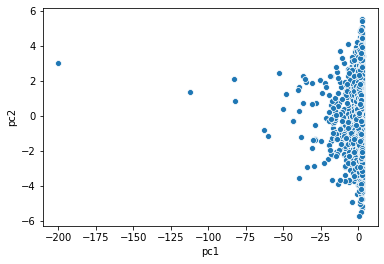

In [14]:
#PCA 
u, s, vt = np.linalg.svd(data2_PCA_fillna2, full_matrices=False)
P = u @ np.diag(s)
df_1st_2_pcs =pd.DataFrame(P[:,0:2], columns=['pc1', 'pc2'])
first_2_pcs = df_1st_2_pcs

#jittered scatter plot (added noise)
first_2_pcs_jittered = first_2_pcs + np.random.normal(0, 0.1, size = (len(first_2_pcs), 2))
sns.scatterplot(data = first_2_pcs_jittered, x = "pc1", y = "pc2");

#a better looking scatter plot with labels
#import plotly.express as px
#px.scatter(data_frame = first_2_pcs_jittered, x = "pc1", y = "pc2", text = list(df_1972_to_2016.index)).update_traces(textposition = 'top center')



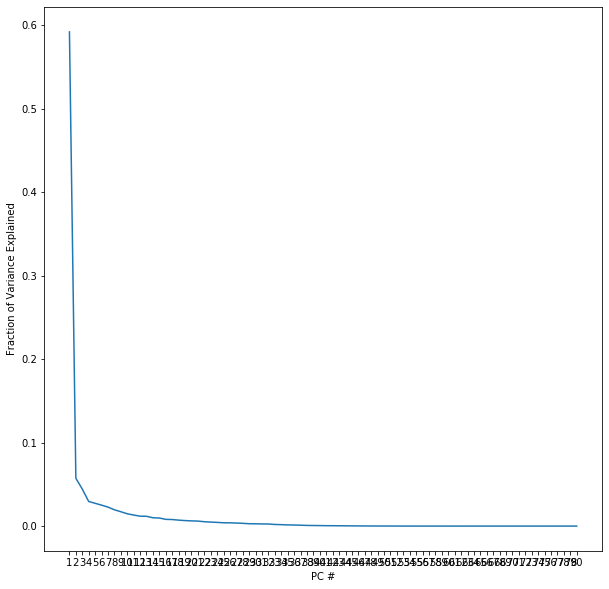

In [15]:
#scree plot
plt.figure(figsize = (10,10))
x = list(range(1, s.shape[0]+1)) 
plt.plot(x, s**2 / sum(s**2)); 
plt.xticks(x, x);
plt.xlabel('PC #');
plt.ylabel('Fraction of Variance Explained');



This plot doesn't make sense LOL why would latitude explain the variance this much. ???

## 4. Train-Test Split

#4 Let's do a train-test split.

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(operate_data2_with_states, test_size=0.1, random_state=42)

Let's do some feature selection. What are some good features to use to predict death rates? 

## Selecting features

Let's draw some scatter plot to see whether some features' values increase with mortality rates. 

In [17]:
plt.figure(figsize = (5,5))
#sns.regplot(operate_data2_with_states['Mortality_Rate'])

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [18]:
operate_data2_with_states

,CountyName,State updated,stay at home,public schools,>500 gatherings,Mortality Rate
0,Autauga,Alabama,737519.000000,737500.000000,737497.000000,3.247029
1,Baldwin,Alabama,737519.000000,737500.000000,737497.000000,3.247029
2,Barbour,Alabama,737519.000000,737500.000000,737497.000000,3.247029
3,Bibb,Alabama,737519.000000,737500.000000,737497.000000,3.247029
4,Blount,Alabama,737519.000000,737500.000000,737497.000000,3.247029
...,...,...,...,...,...,...
3239,Kalawao,Hawaii,737509.000000,737507.000000,737509.000000,1.567944
3240,Ciales Municipio,Puerto Rico,737512.481146,737500.000000,737503.856103,5.366726
3241,Humacao Municipio,Puerto Rico,737512.481146,737500.000000,737503.856103,5.366726
3242,New York City,New York,737512.481146,737502.373408,737503.856103,7.310767


# Classification

## 5. Basic Classification

#5 After selecting features, now we will make training set and test sets. 

In [19]:
X_train = train.drop(['CountyName', 'State updated','Mortality Rate'], axis=1)
Y_train = train['Mortality Rate']

X_train[:5], Y_train[:5]

(       stay at home  public schools  >500 gatherings
 2807  737509.000000        737502.0         737509.0
 2046  737507.000000        737501.0         737499.0
 2110  737507.000000        737501.0         737499.0
 2130  737512.481146        737501.0         737513.0
 1226  737508.000000        737501.0         737501.0,
 2807    4.732254
 2046    4.412052
 2110    4.412052
 2130    5.517241
 1226    3.860112
 Name: Mortality Rate, dtype: float64)

Now we will make a linear regression model, fit the model with training data, and get the training loss. 

Loss function: I will use RMSE now but we can try other loss functions later. 

***Question: *** So what is a satisfying result loss for our model? How do we know how good our model is? 

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics



model = LinearRegression(fit_intercept=True) # should fit intercept be true?
model.fit(X_train, Y_train)

Y_prediction = model.predict(X_train)


training_loss = metrics.mean_squared_error(Y_prediction, Y_train)
print("Training loss: ", training_loss)

Training loss:  1.805616660547656


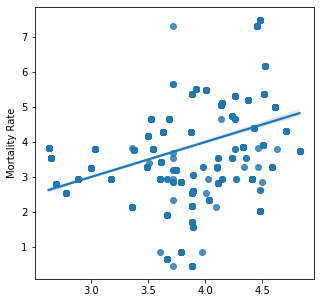

In [21]:
plt.figure(figsize = (5,5))
sns.regplot(Y_prediction, Y_train)

Should also check residual plot to make sure it has no pattern.

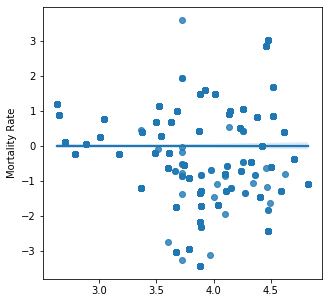

In [22]:
plt.figure(figsize = (5,5))
sns.regplot(Y_prediction, Y_train-Y_prediction)

## 6. Cross-Validation

#6 Now let's perform cross-validation to check whether we are overfitting, and determine which features are useful. 

In [23]:
# perform cross validation
from sklearn import model_selection as ms

# finding which features to use using Cross Validation
errors = []
range_of_num_features = range(1, X_train.shape[1] + 1)
for N in range_of_num_features:
    print(f"Trying first {N} features")
    model = LinearRegression()
    
    # compute the cross validation error
    error = ms.cross_val_score(model, X_train.iloc[:, 0:N], Y_train).mean()
    
    print("\tScore:", error)
    errors.append(error)

best_num_features = np.argmax(errors) + 1
print (best_num_features)
best_err = min(errors)

print(f"Best choice, use the first {best_num_features} features")

Trying first 1 features
	Score: 0.14636331747418546
Trying first 2 features
	Score: 0.16845981263385307
Trying first 3 features
	Score: 0.1701325901522453
3
Best choice, use the first 3 features


## 7. Regularization

#7 Here we perform regularization of data.

## 8. Test

#8 Here we will test our model on test set and find its test accuracy. 

## 9. Conclusion

#9 We can also fit other models (like logistic model?) with our training data, and test on test set about their accuracy.